In [1]:
import numpy as np

node_features = np.load('Downloads/node_features.npy')


In [2]:
if node_features.shape[2] == 1:
    node_features = np.squeeze(node_features)


In [3]:
demand_column = node_features[:, -1, :]


In [4]:
import pandas as pd

adjacency_matrix = pd.read_csv('Downloads/neighbor_matrix.csv', header=None).values


In [5]:
distance_matrix = pd.read_csv('Downloads/distance_matrix.csv', header=None).values


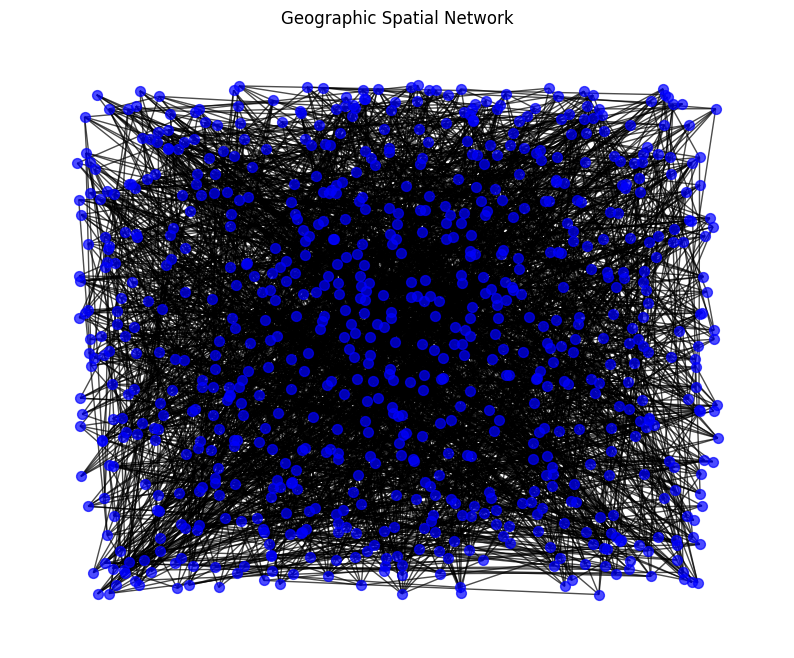

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load adjacency matrix
adjacency_matrix = pd.read_csv('Downloads/neighbor_matrix.csv', header=None).values

# Load geographic coordinates (latitude and longitude)
# Replace with your actual coordinates for each node
coordinates = np.random.rand(adjacency_matrix.shape[0], 2)

# Create a graph from the adjacency matrix
graph = nx.from_numpy_array(adjacency_matrix)

# Set node positions using geographic coordinates
pos = {i: (coordinates[i, 0], coordinates[i, 1]) for i in range(adjacency_matrix.shape[0])}

# Visualize the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx(graph, pos=pos, node_size=50, node_color='b', alpha=0.7, with_labels=False)
plt.title('Geographic Spatial Network')
plt.axis('off')
plt.show()


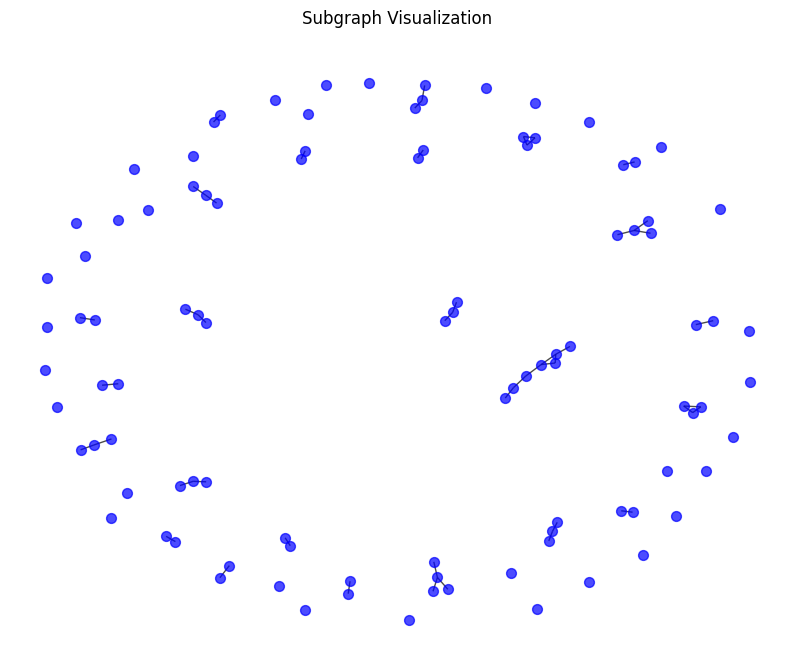

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load adjacency matrix
adjacency_matrix = pd.read_csv('Downloads/neighbor_matrix.csv', header=None).values

# Load geographic coordinates (latitude and longitude)
# Replace with your actual coordinates for each node
coordinates = np.random.rand(adjacency_matrix.shape[0], 2)

# Create a graph from the adjacency matrix
graph = nx.from_numpy_array(adjacency_matrix)

# Define the number of nodes to sample
num_nodes_to_sample = 100

# Sample a subset of nodes
sampled_nodes = np.random.choice(graph.nodes(), size=num_nodes_to_sample, replace=False)

# Create a subgraph with the sampled nodes
subgraph = graph.subgraph(sampled_nodes)

# Set node positions using geographic coordinates
pos = {node: (coordinates[node, 0], coordinates[node, 1]) for node in subgraph.nodes()}

# Choose a network layout algorithm
layout = nx.spring_layout

# Apply the layout algorithm to position the nodes
pos = layout(subgraph, pos=pos)

# Visualize the subgraph
plt.figure(figsize=(10, 8))
nx.draw_networkx(subgraph, pos=pos, node_size=50, node_color='b', alpha=0.7, with_labels=False)
plt.title('Subgraph Visualization')
plt.axis('off')
plt.show()


The graph represents a network where the nodes represent Chicago census tracts. Each node in the graph corresponds to a specific census tract in Chicago, which is a geographical region used for statistical purposes.

The edges between the nodes are determined by the adjacency matrix. In this case, the adjacency matrix is binary, where a value of 1 indicates that two nodes (census tracts) are adjacent or touching each other, and a value of 0 means they are not adjacent.

In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define GNN model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.gcn1 = GCN(input_dim, hidden_dim)
        self.gcn2 = GCN(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = self.gcn1(x, adj)
        x = torch.relu(x)
        x = self.gcn2(x, adj)
        return x

class GCN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x)
        x = self.linear(x)
        return x


In [9]:
# Define dataset class
class GraphDataset(Dataset):
    def __init__(self, node_features, demand_column, adjacency_matrix):
        self.node_features = node_features
        self.demand_column = demand_column
        self.adjacency_matrix = adjacency_matrix

    def __len__(self):
        return len(self.node_features)

    def __getitem__(self, idx):
        x = self.node_features[idx]
        y = self.demand_column[idx]
        adj = self.adjacency_matrix
        return x, y, adj

In [10]:
# Data Preparation
node_features = np.load('Downloads/node_features.npy')
demand_column = node_features[:, -1, :]
adjacency_matrix = pd.read_csv('Downloads/neighbor_matrix.csv', header=None).values

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Normalize node features
scaler = MinMaxScaler()
reshaped_node_features = node_features.reshape(node_features.shape[0], -1)  # Reshape to 2D
normalized_node_features = scaler.fit_transform(reshaped_node_features)

# Normalize demand column
normalized_demand_column = scaler.fit_transform(demand_column.reshape(-1, 1))

# Use normalized data in your dataset
dataset = GraphDataset(normalized_node_features, normalized_demand_column, adjacency_matrix)


In [12]:
# Graph Construction
graph = nx.from_numpy_array(adjacency_matrix)
nx.set_node_attributes(graph, values=dict(zip(range(len(node_features)), node_features)), name='features')
nx.set_node_attributes(graph, values=dict(zip(range(len(demand_column)), demand_column)), name='demand')

In [14]:
# Define GNN model
input_dim = node_features.shape[1]
hidden_dim = 64
output_dim = 1
model = GNN(input_dim, hidden_dim, output_dim).to(device)

In [15]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
# Prepare dataset and dataloader
dataset = GraphDataset(node_features, demand_column, adjacency_matrix)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
# Split the dataset into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the sizes of each split
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Perform the data splitting
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for training, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
num_epochs = 5
print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    num_batches = len(train_dataloader)
    for batch_idx, batch in enumerate(train_dataloader):
        x, y, adj = batch
        x = x.transpose(1, 2)
        x = x.float()
        adj = adj.float()
        optimizer.zero_grad()
        output = model(x, adj)
        output = output.reshape(-1, output_dim)
        y = y.reshape(-1)
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        print("Training - Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, batch_idx+1, num_batches, loss.item()))
    train_loss /= len(train_dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    num_val_batches = len(val_dataloader)
    for batch_idx, batch in enumerate(val_dataloader):
        x, y, adj = batch
        x = x.transpose(1, 2)
        x = x.float()
        adj = adj.float()
        output = model(x, adj)
        output = output.reshape(-1, output_dim)
        y = y.reshape(-1)
        loss = criterion(output, y.float())
        val_loss += loss.item() * x.size(0)
        print("Validation - Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, batch_idx+1, num_val_batches, loss.item()))
    val_loss /= len(val_dataset)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Evaluation on the test set
model.eval()
test_loss = 0.0
num_test_batches = len(test_dataloader)  # Get the total number of batches in the test dataloader
with torch.no_grad():
    print("Starting test...")
    for batch_idx, batch in enumerate(test_dataloader):
        x, y, adj = batch
        x = x.transpose(1, 2)
        x = x.float()
        adj = adj.float()
        output = model(x, adj)
        output = output.reshape(-1, output_dim)
        y = y.reshape(-1)
        loss = criterion(output, y.float())
        test_loss += loss.item() * x.size(0)
        print("Batch [{}/{}], Loss: {:.4f}".format(batch_idx+1, num_test_batches, loss.item()))  # Print batch progress
test_loss /= len(test_dataset)  # Divide by the total number of samples in the test dataset

print(f'Test Loss: {test_loss}')



Starting training...


C:\Users\johnn\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([24768])) that is different to the input size (torch.Size([24768, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training - Epoch [1/5], Batch [1/510], Loss: 13595.8926
Training - Epoch [1/5], Batch [2/510], Loss: 3855.5896
Training - Epoch [1/5], Batch [3/510], Loss: 6771.6743
Training - Epoch [1/5], Batch [4/510], Loss: 5950.5654
Training - Epoch [1/5], Batch [5/510], Loss: 685.7277
Training - Epoch [1/5], Batch [6/510], Loss: 822.6371
Training - Epoch [1/5], Batch [7/510], Loss: 2432.0320
Training - Epoch [1/5], Batch [8/510], Loss: 2410.7019
Training - Epoch [1/5], Batch [9/510], Loss: 2459.1194
Training - Epoch [1/5], Batch [10/510], Loss: 409.9389
Training - Epoch [1/5], Batch [11/510], Loss: 132.6104
Training - Epoch [1/5], Batch [12/510], Loss: 617.3769
Training - Epoch [1/5], Batch [13/510], Loss: 1452.5016
Training - Epoch [1/5], Batch [14/510], Loss: 1602.4924
Training - Epoch [1/5], Batch [15/510], Loss: 739.7924
Training - Epoch [1/5], Batch [16/510], Loss: 143.4534
Training - Epoch [1/5], Batch [17/510], Loss: 191.0460
Training - Epoch [1/5], Batch [18/510], Loss: 356.2980
Training 

C:\Users\johnn\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([20124])) that is different to the input size (torch.Size([20124, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training - Epoch [1/5], Batch [510/510], Loss: 87.0362
Validation - Epoch [1/5], Batch [1/146], Loss: 101.8810
Validation - Epoch [1/5], Batch [2/146], Loss: 92.4174
Validation - Epoch [1/5], Batch [3/146], Loss: 73.4867
Validation - Epoch [1/5], Batch [4/146], Loss: 101.1031
Validation - Epoch [1/5], Batch [5/146], Loss: 62.6531
Validation - Epoch [1/5], Batch [6/146], Loss: 108.0793
Validation - Epoch [1/5], Batch [7/146], Loss: 88.1266
Validation - Epoch [1/5], Batch [8/146], Loss: 78.2482
Validation - Epoch [1/5], Batch [9/146], Loss: 90.5694
Validation - Epoch [1/5], Batch [10/146], Loss: 101.0647
Validation - Epoch [1/5], Batch [11/146], Loss: 108.8881
Validation - Epoch [1/5], Batch [12/146], Loss: 78.7028
Validation - Epoch [1/5], Batch [13/146], Loss: 100.9598
Validation - Epoch [1/5], Batch [14/146], Loss: 66.6045
Validation - Epoch [1/5], Batch [15/146], Loss: 92.6002
Validation - Epoch [1/5], Batch [16/146], Loss: 61.7009
Validation - Epoch [1/5], Batch [17/146], Loss: 103.

C:\Users\johnn\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16254])) that is different to the input size (torch.Size([16254, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation - Epoch [1/5], Batch [146/146], Loss: 89.2011
Epoch: 1, Train Loss: 185.96221135915664, Val Loss: 88.81742234589127
Training - Epoch [2/5], Batch [1/510], Loss: 95.6204
Training - Epoch [2/5], Batch [2/510], Loss: 95.1771
Training - Epoch [2/5], Batch [3/510], Loss: 85.0722
Training - Epoch [2/5], Batch [4/510], Loss: 73.8801
Training - Epoch [2/5], Batch [5/510], Loss: 94.7275
Training - Epoch [2/5], Batch [6/510], Loss: 88.8814
Training - Epoch [2/5], Batch [7/510], Loss: 109.6357
Training - Epoch [2/5], Batch [8/510], Loss: 95.4050
Training - Epoch [2/5], Batch [9/510], Loss: 96.0121
Training - Epoch [2/5], Batch [10/510], Loss: 91.3352
Training - Epoch [2/5], Batch [11/510], Loss: 86.0842
Training - Epoch [2/5], Batch [12/510], Loss: 86.7722
Training - Epoch [2/5], Batch [13/510], Loss: 92.8421
Training - Epoch [2/5], Batch [14/510], Loss: 83.2198
Training - Epoch [2/5], Batch [15/510], Loss: 87.6932
Training - Epoch [2/5], Batch [16/510], Loss: 83.3584
Training - Epoch 

C:\Users\johnn\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([20898])) that is different to the input size (torch.Size([20898, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch [73/73], Loss: 102.4785
Test Loss: 85.49569463545751


The code implements a GNN model for a rideshare demand prediction task on a spatial network represented by Chicago census tracts. The model is trained using the node features, adjacency matrix, and demand column data. The goal is to predict the demand based on the historical rideshare data and the spatial relationships between the census tracts.
